# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/gianluca/Documents/Metodos Numericos/tp2/bin/python (found version "3.8.2") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/gianluca/Documents/Metodos Numericos/github_g

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/gianluca/Documents/Metodos Numericos/github_grupal/metodos-num/tp2/notebooks
Python 3.8.2


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [4]:
df_train[:10]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [5]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [6]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 0


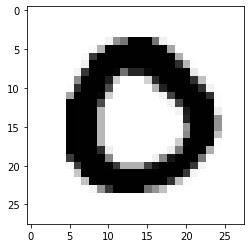

In [7]:
import matplotlib.pyplot as plt

num = 4

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [8]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
8    0.0954
4    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [72]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [45]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca

In [68]:
import numpy as np
import pandas as pd


def numpy_to_csv(x,val,alpha,nset):
    df_x = pd.DataFrame(data=x)
    df_x.to_csv(f"transformaciones/{nset}_{alpha}_train.csv",index=False)
    df_val = pd.DataFrame(data=val)
    df_val.to_csv(f"transformaciones/{nset}_{alpha}_val.csv",index=False)


In [70]:
numpy_to_csv(X_pca,X_val_pca,alpha,5000)


In [69]:
alphas = [i*10 for i in range(1,31)]
Ks = [i*10 for i in range(1,21)]

In [73]:
col_alphas = []
col_k = []
precisiones = []
for alpha in alphas :
    X_pca, X_val_pca = pca(alpha,X_train,X_val)
    numpy_to_csv(X_pca,X_val_pca,alpha,5000)
    for k in Ks :
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_pca, y_train)
        
        y_pred = clf.predict(X_val_pca)
        acc = accuracy_score(y_val, y_pred)
        #para armar dsp el dataframe
        precisiones.append(acc)
        col_alphas.append(alpha)
        col_k.append(k)
        

In [105]:
dat = pd.DataFrame({"Alpha":col_alphas,"K":col_k,"Precisión": precisiones})
dat = dat.pivot("Alpha","K","Precisión")
dat

K,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200
Alpha,,,,,,,,,,,,,,,,,,,,
10,0.886,0.876,0.871,0.867,0.862,0.854,0.853,0.848,0.851,0.846,0.841,0.835,0.833,0.833,0.832,0.830,0.824,0.817,0.815,0.806
20,0.941,0.918,0.920,0.912,0.911,0.907,0.897,0.889,0.887,0.882,0.881,0.875,0.876,0.866,0.871,0.869,0.864,0.860,0.858,0.857
30,0.942,0.931,0.924,0.916,0.908,0.904,0.899,0.891,0.883,0.880,0.869,0.867,0.859,0.860,0.853,0.854,0.851,0.849,0.845,0.847
40,0.939,0.927,0.921,0.912,0.904,0.903,0.896,0.881,0.878,0.873,0.872,0.867,0.863,0.855,0.852,0.847,0.845,0.839,0.837,0.831
50,0.937,0.926,0.924,0.912,0.903,0.894,0.886,0.879,0.874,0.869,0.864,0.861,0.857,0.853,0.848,0.850,0.844,0.836,0.828,0.824
60,0.933,0.927,0.924,0.913,0.895,0.894,0.883,0.878,0.870,0.867,0.861,0.854,0.849,0.844,0.844,0.833,0.829,0.822,0.821,0.815
70,0.940,0.918,0.919,0.910,0.899,0.889,0.885,0.871,0.867,0.856,0.852,0.847,0.840,0.836,0.831,0.823,0.821,0.817,0.815,0.810
80,0.935,0.921,0.914,0.908,0.900,0.883,0.883,0.864,0.864,0.855,0.852,0.843,0.836,0.828,0.822,0.809,0.813,0.811,0.811,0.806
90,0.931,0.918,0.913,0.908,0.893,0.886,0.881,0.870,0.858,0.857,0.844,0.841,0.833,0.821,0.817,0.812,0.810,0.809,0.805,0.803


In [98]:
dat.to_csv("rangoAplhas_10-300yrangoK_10-200.csv",index = True,header = True)

In [123]:
indmax = precisiones.index(max(precisiones))
col_alphas_mod[indmax],col_k[indmax]

(30, 10)

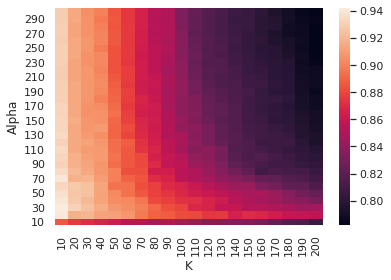

In [108]:
import numpy as np

import seaborn as sns; sns.set()


hmap = sns.heatmap(dat)#,cmap = "YlGnBu") # colores de mapa claros
hmap.invert_yaxis()

In [79]:
def train(k,alpha,X,y,X_val,y_val):
    X_pca, X_val_pca = pca(alpha,X,X_val)

    clf = metnum.KNNClassifier(k)
    clf.fit(X_pca, y)
    y_pred = clf.predict(X_val_pca)

    acc = accuracy_score(y_val, y_pred)
    print("Accuracy: {}".format(acc))
